In [21]:
import numpy as np
import glob
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from collections import deque

### Import data set

In [2]:
# Import car and non car images
car = glob.glob('./Data/vehicles/**/*.png')
non_car = glob.glob('./Data/non-vehicles/**/*.png')

print("Number of images with cars: {}").format(len(car))
print("Number of images without cars: {}").format(len(non_car))

car_images = []
noncar_images = []

for car_img in car:
    img = cv2.imread(car_img)
    car_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
for noncar_img in non_car:
    img = cv2.imread(noncar_img)
    noncar_images.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Number of images with cars: 8792
Number of images without cars: 8968


### Select and display random image from both car and non-car classes

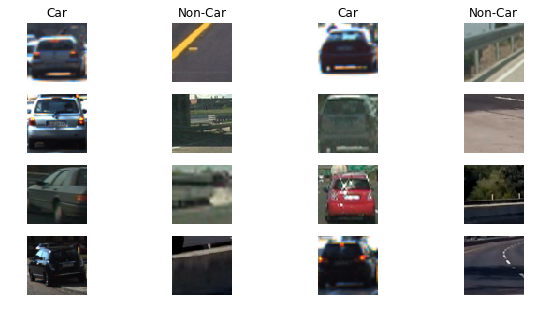

In [3]:
f, axs = plt.subplots(4,4, figsize=(10,5))
axs = axs.ravel()

# Plot random images from both data sets

for i in range(0,16):
    if (i % 2 == 0):
        rand_img = np.random.randint(0,len(car))
        axs[i].imshow(car_images[rand_img])
        axs[i].axis('off')
        
    else:
        rand_img = np.random.randint(0,len(non_car))
        axs[i].imshow(noncar_images[rand_img])
        axs[i].axis('off')
        
    axs[0].set_title('Car')
    axs[1].set_title('Non-Car')
    axs[2].set_title('Car')
    axs[3].set_title('Non-Car')
plt.savefig('./output_images/car_noncar.png')

### Find HOG features of an example image in each class

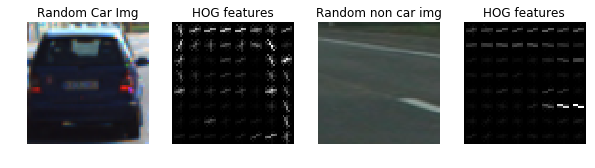

In [4]:
# Define function to extract HOG features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# Extract HOG features for random car image
rand_img = np.random.randint(0,len(car))    
rand_car = car_images[rand_img]
hog_features, hog_car = get_hog_features(rand_car[:,:,0], orient=9, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

# Extract Hog features from random non car image
rand_img = np.random.randint(0,len(non_car))    
rand_noncar = noncar_images[rand_img]
hog_features, hog_noncar = get_hog_features(rand_noncar[:,:,0], orient=9, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

# Plot extracted HOG features

f, axs = plt.subplots(1,4,figsize=(10,5))
axs = axs.ravel()
axs[0].imshow(rand_car)
axs[0].set_title("Random Car Img")
axs[0].axis('off')
axs[1].imshow(hog_car,cmap='gray')
axs[1].set_title("HOG features")
axs[1].axis('off')
axs[2].imshow(rand_noncar)
axs[2].set_title("Random non car img")
axs[2].axis('off')
axs[3].imshow(hog_noncar,cmap='gray')
axs[3].set_title("HOG features")
axs[3].axis('off')
plt.savefig('./output_images/hog_features.png')

### Define useful functions

In [5]:
# Function to resize image and create vector
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
# Function to extract histogram of color channels
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Function to draw boxes on a given image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Function to add boxes to heat map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
# Function to apply threshold to given heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Funciton to draw bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Function to extract all features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Calculate spatial features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Define parameters and extract features

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 4 # HOG pixels per cell
cell_per_block = 16 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print("Total number of  data points: ",len(y))
print("Number of training examples: ",len(y_train))
print("Number of test examples: ",len(y_test))

('Total number of  data points: ', 17760)
('Number of training examples: ', 14208)
('Number of test examples: ', 3552)


### Normalize data

In [7]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

### Train SVM classifier

In [8]:
# Use a linear SVC 
svc = svm.LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(26.18, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9699)
('My SVC predicts: ', array([0., 0., 1., 1., 0., 1., 0., 1., 0., 0.]))
('For these', 10, 'labels: ', array([0., 0., 1., 1., 0., 0., 0., 1., 0., 0.]))
(0.0011, 'Seconds to predict', 10, 'labels with SVC')


### Define function to find cars in a given y pixel range

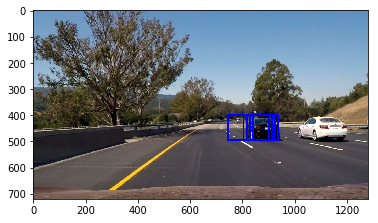

In [10]:
boxes = []
# Function to look for cars in a given y pixel range
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins, spatial_feat, hist_feat, boxes):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            test_features = hog_features.reshape(1,-1)
            # Get color features
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                test_features = np.hstack((hist_features.reshape(1,-1), test_features))
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                test_features = np.hstack((spatial_features.reshape(1,-1), test_features))
            

            # Scale features and make a prediction
            test_features = X_scaler.transform(test_features)    
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            confidence = svc.decision_function(test_features)
            
            if test_prediction == 1 and confidence > 20:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,boxes
    
ystart = 400
ystop = 506
scale = 1.5
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                          pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, boxes)

plt.imshow(out_img)

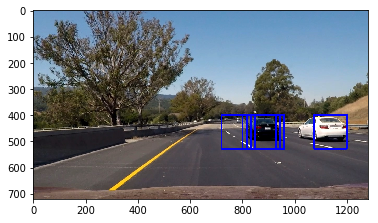

In [30]:
# Test find_cars function with different scale settings
ystart = 400
ystop = 528
scale = 2.0
out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                          pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, boxes)

plt.imshow(out_img)
plt.savefig('./output_images/sliding_search.png')

### Create heat map of the image

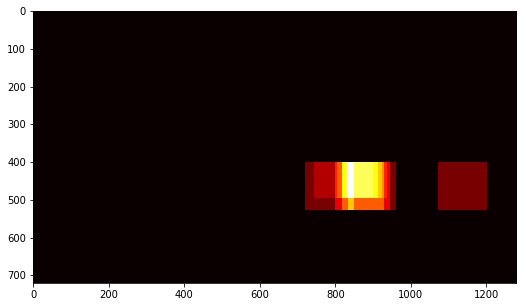

In [45]:
heatmap_img = np.zeros_like(img[:,:,0])

heatmap_img = add_heat(heatmap_img, boxes)
plt.figure(figsize=(10,5))
plt.imshow(heatmap_img, cmap='hot')

### Add threshold to heatmap

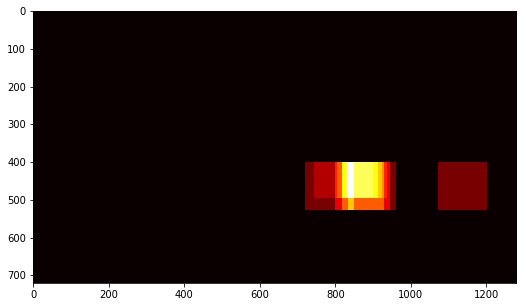

In [44]:
heatmap_img = apply_threshold(heatmap_img, 0)
plt.figure(figsize=(10,5))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('./output_images/heat_map.png')

(2, 'cars found')


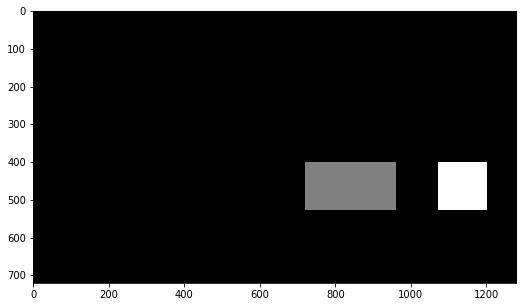

In [43]:
# Print and show group heat maps
labels = label(heatmap_img)
plt.figure(figsize=(10,5))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
plt.savefig('./output_images/cars_found.png')

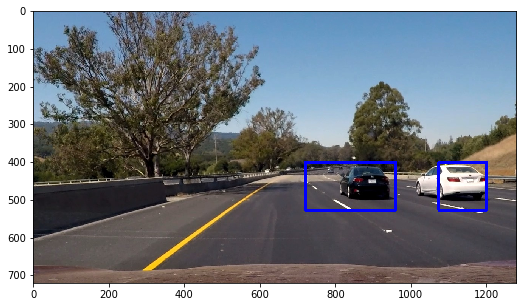

In [46]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,5))
plt.imshow(draw_img)
plt.savefig('./output_images/final_detected.png')

### Define final function to be used in video

In [17]:
history = deque(maxlen = 6)

# Define final pipeline

def extract_cars(img):

    rectangles = []
    boxes = []

    ystart = 400
    ystop = 500
    scale = 1.0
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat, hist_feat, boxes)
    
    ystart = 416
    ystop = 500
    scale = 1.2
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat, hist_feat, boxes)

    ystart = 422
    ystop = 528
    scale = 1.5
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat, hist_feat, boxes)

    ystart = 400
    ystop = 596
    scale = 2.0
    out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,spatial_feat, hist_feat, boxes)
    
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, boxes)

    # Apply threshold to help remove false positives
    threshold = 4
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)
    history.append(current_heatmap)
    
    heatmap = np.zeros_like(current_heatmap).astype(np.float)
    for heat in history:
        heatmap = heatmap + heat

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img,rects = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Test function on test images

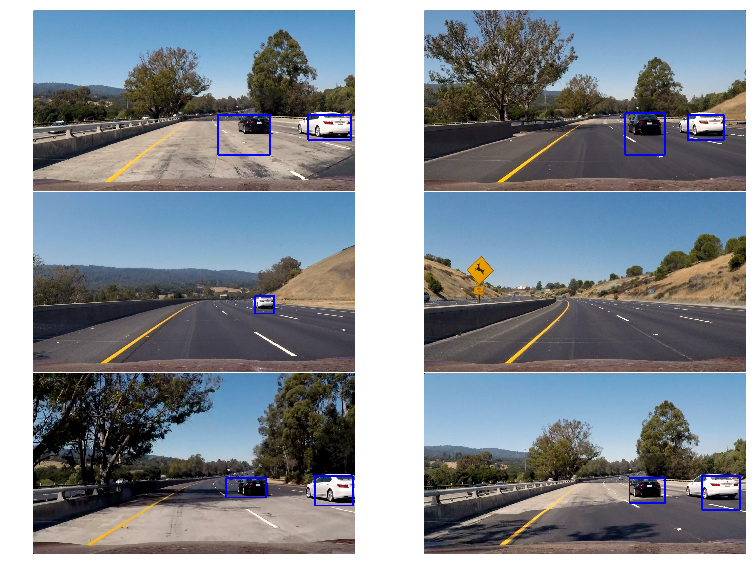

In [47]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(14,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    history = deque(maxlen = 2)
    axs[i].imshow(extract_cars(mpimg.imread(im)))
    axs[i].axis('off')
plt.savefig('./output_images/final_detections.png')

### Apply pipeline on test video

In [19]:
test_out_file = 'test_video_output.mp4'
history = deque(maxlen = 2)
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(extract_cars)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 32.2 s, sys: 3.24 s, total: 35.4 s
Wall time: 36.3 s


### Apply pipeline on project video

In [25]:
project_out_file = 'project_video_output.mp4'
history = deque(maxlen = 6)
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(extract_cars)
%time clip_test_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [19:35<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 17min 36s, sys: 1min 49s, total: 19min 25s
Wall time: 19min 35s
